# Bernoulli HMM Example Notebook

Modified from https://github.com/lindermanlab/ssm-jax-refactor/blob/main/notebooks/bernoulli-hmm-example.ipynb

Changes: It uses pyprobml's dynamax library, and finds the permutation between inferrred and true latent state labels in a different way.


In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/dynamax.git
    import dynamax
dynamax.__file__

In [1]:
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

#### Imports and Plotting Functions 

In [2]:
import jax.random as jr
import jax.numpy as jnp
from jax import vmap

import tensorflow_probability.substrates.jax.distributions as tfd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pprint import pprint

from dynamax.hmm.models import BernoulliHMM

In [3]:
def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    Reference:
    https://github.com/lindermanlab/ssm/blob/646e1889ec9a7efb37d4153f7034c258745c83a5/ssm/plots.py#L20
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = jnp.linspace(0, 1, ncolors)

    reds = []
    greens = []
    blues = []
    alphas = []
    for b, c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1.0, 1.0))

    cdict = {"red": tuple(reds), "green": tuple(greens), "blue": tuple(blues), "alpha": tuple(alphas)}

    cmap = LinearSegmentedColormap("grad_colormap", cdict, nsteps)
    return cmap

In [4]:
def find_permutation(z1, z2):
    K1 = z1.max() + 1
    K2 = z2.max() + 1

    perm = []
    for k1 in range(K1):
        indices = jnp.where(z1 == k1)[0]
        counts = jnp.bincount(z2[indices])
        perm.append(jnp.argmax(counts))

    return jnp.array(perm)

In [5]:
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue", "red", "amber", "faded green", "dusty purple", "orange"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def compare_transition_matrix(true_matrix, test_matrix):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (10, 5)
    if is_latexify_enabled():
        figsize = None
    latexify(width_scale_factor=1, fig_height=1.5)
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes(
        [
            axs[1].get_position().x1 + 0.07,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().y1 - axs[1].get_position().y0,
        ]
    )
    plt.colorbar(out, cax=cax)
    plt.show()


def plot_posterior_states(Ez, states, perm):
    # latexify(width_scale_factor=1, fig_height=1.5)
    figsize = (25, 5)
    if is_latexify_enabled():
        figsize = None
    plt.figure(figsize=figsize)
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State", linewidth=1)
    plt.plot(Ez.T[perm].argmax(axis=0), "--", label="Predicted State", linewidth=1)
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title("Predicted vs. Ground Truth Latent State")

# Bernoulli HMM

### Let's create a true model

In [6]:
num_states = 5
num_channels = 10
true_hmm = BernoulliHMM(num_states, num_channels, 
                        emission_prior_concentration0=1.0, 
                        emission_prior_concentration1=1.0)

In [7]:
params, param_props = true_hmm.random_initialization(jr.PRNGKey(0))
pprint(params)

{'emissions': {'probs': DeviceArray([[0.58562934, 0.79165304, 0.7716738 , 0.8634541 , 0.7152256 ,
              0.66359174, 0.01031685, 0.4453088 , 0.45356536, 0.44767928],
             [0.1148206 , 0.6768606 , 0.14519882, 0.47049963, 0.8891028 ,
              0.24046588, 0.84166324, 0.86564577, 0.7183422 , 0.53284216],
             [0.83776927, 0.3756528 , 0.7556994 , 0.9066334 , 0.30898416,
              0.7880579 , 0.6446228 , 0.58154047, 0.49281883, 0.03052318],
             [0.34637475, 0.47827482, 0.6894927 , 0.8976035 , 0.4620744 ,
              0.09265065, 0.4799403 , 0.859169  , 0.31629694, 0.81412923],
             [0.4706018 , 0.5590676 , 0.73437774, 0.1520487 , 0.24040079,
              0.99387634, 0.99134445, 0.22928429, 0.6455829 , 0.92835677]],            dtype=float32)},
 'initial': {'probs': DeviceArray([0.09509773, 0.06679419, 0.3790278 , 0.41402712, 0.04505308],            dtype=float32)},
 'transitions': {'transition_matrix': DeviceArray([[0.0259612 , 0.34117457, 0.

In [8]:
params["initial"]["probs"] = jnp.ones((num_states,)) / (num_states * 1.0)
params["transitions"]["transition_matrix"] = 0.90 * jnp.eye(num_states) + 0.10 * jnp.ones((num_states, num_states)) / num_states
# params["emissions"]["probs"] = probs_prior.sample(seed=jr.PRNGKey(0), sample_shape=(num_states, num_channels))


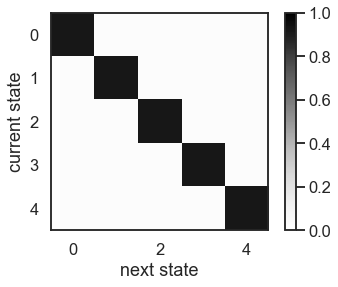

In [9]:
plot_transition_matrix(params["transitions"]["transition_matrix"])

In [10]:
print("Emission probabilities (num states x num emission_dims (aka channels)):")
print(params["emissions"]["probs"])

Emission probabilities (num states x num emission_dims (aka channels)):
[[0.58562934 0.79165304 0.7716738  0.8634541  0.7152256  0.66359174
  0.01031685 0.4453088  0.45356536 0.44767928]
 [0.1148206  0.6768606  0.14519882 0.47049963 0.8891028  0.24046588
  0.84166324 0.86564577 0.7183422  0.53284216]
 [0.83776927 0.3756528  0.7556994  0.9066334  0.30898416 0.7880579
  0.6446228  0.58154047 0.49281883 0.03052318]
 [0.34637475 0.47827482 0.6894927  0.8976035  0.4620744  0.09265065
  0.4799403  0.859169   0.31629694 0.81412923]
 [0.4706018  0.5590676  0.73437774 0.1520487  0.24040079 0.99387634
  0.99134445 0.22928429 0.6455829  0.92835677]]


### From the true model, we can sample synthetic data

In [11]:
rng = jr.PRNGKey(0)
num_timesteps = 500

states, data = true_hmm.sample(params, rng, num_timesteps)

### Let's view the synthetic data

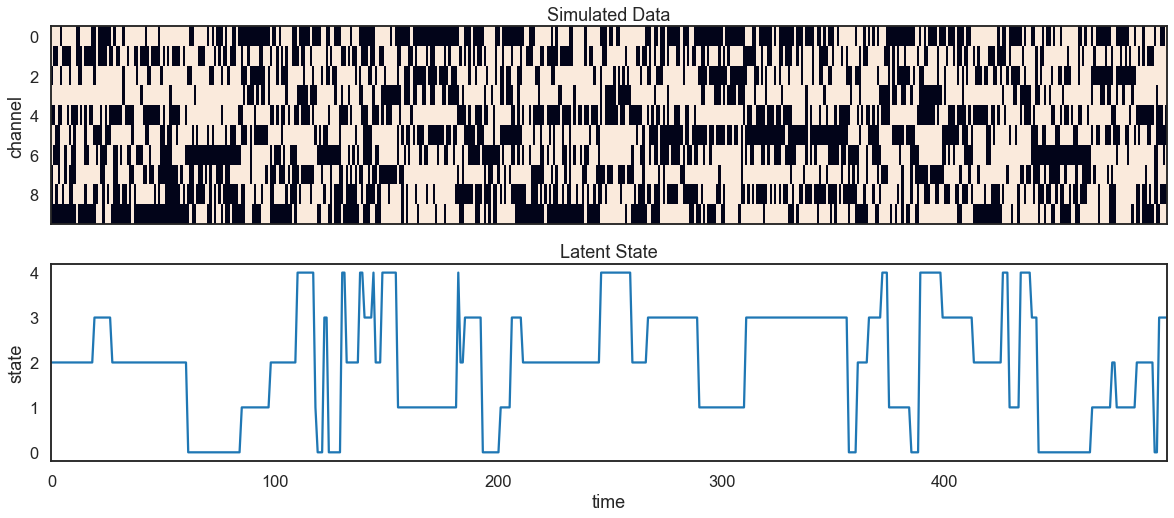

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("channel")
axs[0].set_title("Simulated Data")
axs[1].plot(states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")
/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


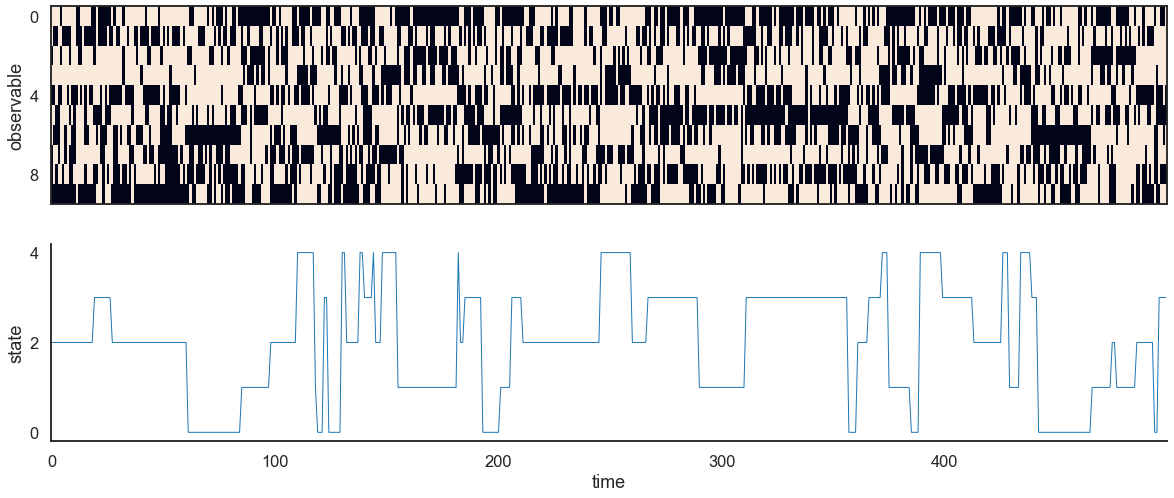

In [13]:
latexify(width_scale_factor=1, fig_height=2)
figsize = (20, 8)
if is_latexify_enabled():
    figsize = None
fig, axs = plt.subplots(2, 1, sharex=True, figsize=figsize)
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("observable")
axs[0].set_yticks([0, 4, 8])
axs[1].plot(states, linewidth=1)
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
axs[1].set_yticks([0, 2, 4])
axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
if is_latexify_enabled():
    plt.subplots_adjust(hspace=4)
savefig("bernoulli-hmm-data")
plt.show()

## Fit HMM using exact EM update

In [14]:
test_hmm = BernoulliHMM(num_states, num_channels)
test_params, test_param_props = test_hmm.random_initialization(jr.PRNGKey(1))

In [15]:
num_iters = 20
test_params, lps = test_hmm.fit_em(test_params, test_param_props, data, num_iters=num_iters)

100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Text(0, 0.5, 'log likelihood')

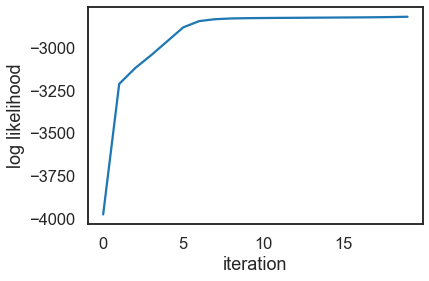

In [16]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

In [17]:
test_params["transitions"]["transition_matrix"]

DeviceArray([[0.77578455, 0.03252222, 0.07430587, 0.08684887, 0.03053849],
             [0.05945186, 0.63074064, 0.09437503, 0.00284762, 0.21258484],
             [0.01040691, 0.05333097, 0.89655405, 0.02583747, 0.01387055],
             [0.04375789, 0.02126712, 0.02734772, 0.88228947, 0.02533784],
             [0.01265132, 0.2745264 , 0.0236899 , 0.02338587, 0.66574657]],            dtype=float32)

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


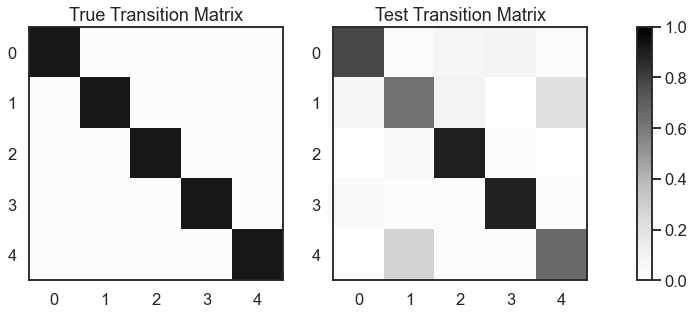

In [18]:
# Compare the transition matrices
compare_transition_matrix(params["transitions"]["transition_matrix"], test_params["transitions"]["transition_matrix"])

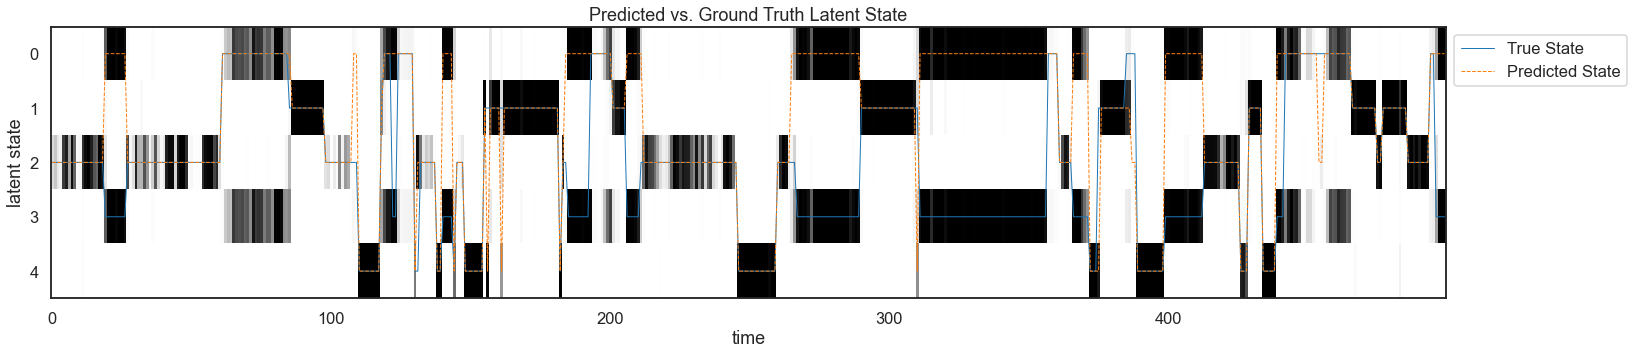

In [19]:
# Posterior distribution
posterior = test_hmm.smoother(test_params, data)
Ez = posterior.smoothed_probs
perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
plot_posterior_states(Ez, states, perm)

# Fit Bernoulli Over Multiple Trials

In [20]:
rng = jr.PRNGKey(0)
num_trials = 5
keys = jr.split(rng, num_trials)
num_timesteps = 500

from functools import partial

all_states, all_data = vmap(partial(true_hmm.sample, params, num_timesteps=num_timesteps))(keys)

In [21]:
# Now we have a batch dimension of size `num_trials`
print(all_states.shape)
print(all_data.shape)

(5, 500)
(5, 500, 10)


In [22]:
num_iters = 100
test_parms, test_param_props = test_hmm.random_initialization(jr.PRNGKey(2))
test_params, lps = test_hmm.fit_em(test_params, test_param_props, all_data, num_iters=100)

100%|██████████| 100/100 [00:00<00:00, 101.19it/s]


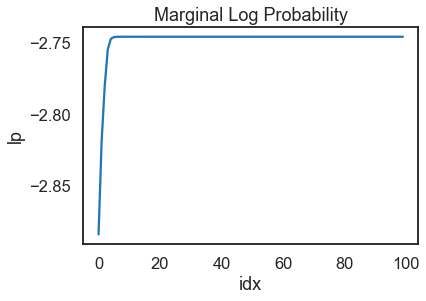

In [23]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(jnp.array(lps) / data.size)

/Users/scott/miniconda3/envs/dynamax/lib/python3.9/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


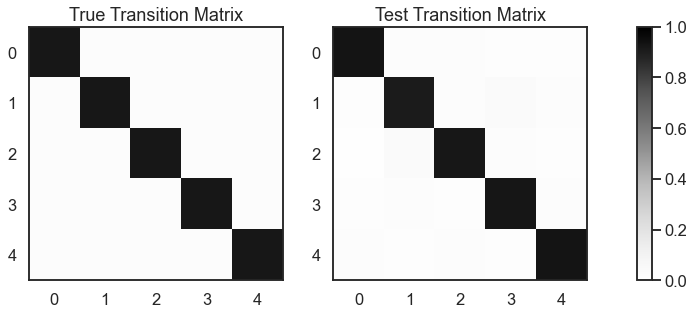

In [24]:
# Compare the transition matrices
compare_transition_matrix(params["transitions"]["transition_matrix"], test_params["transitions"]["transition_matrix"])

===== Trial: 0 =====
===== Trial: 1 =====
===== Trial: 2 =====


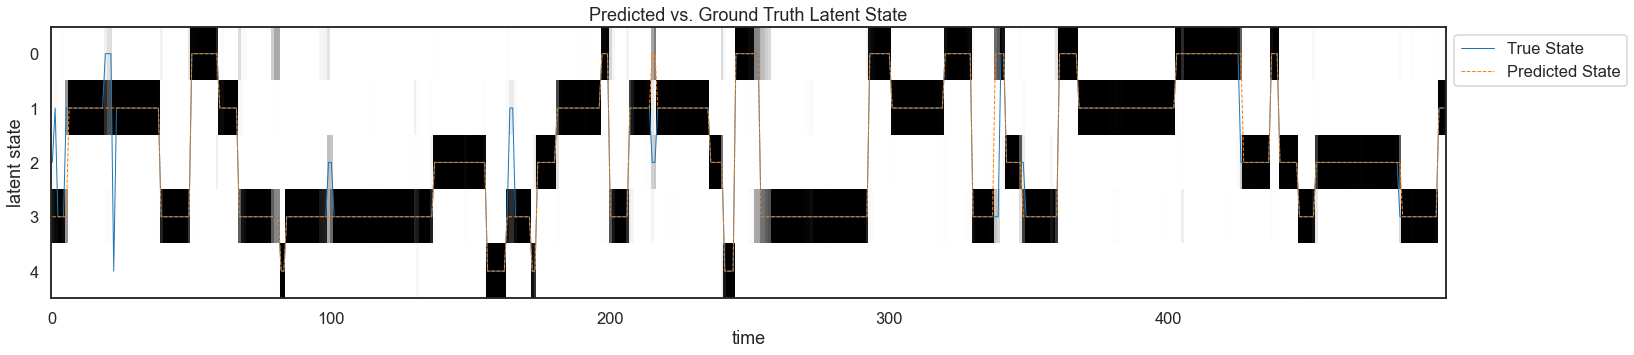

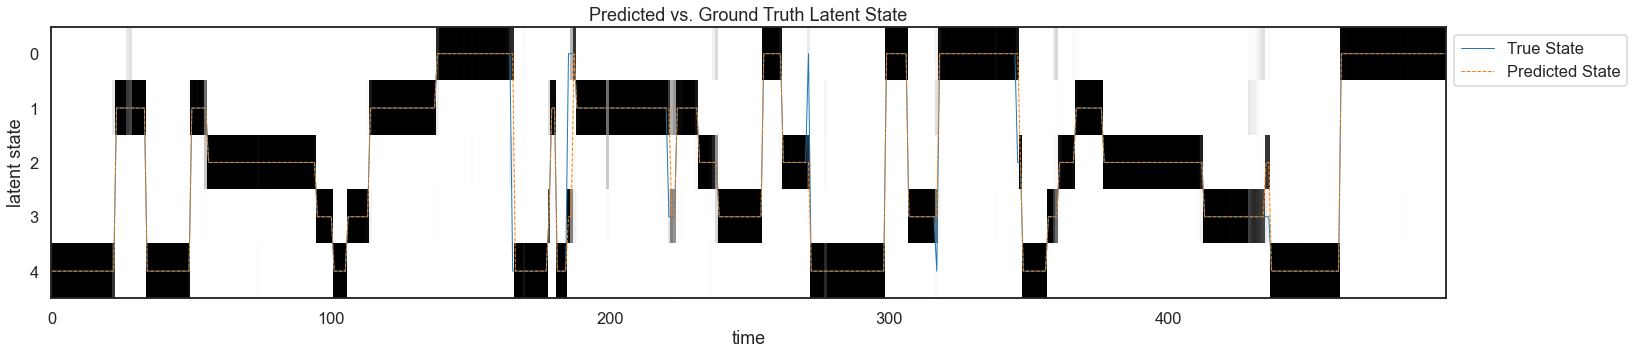

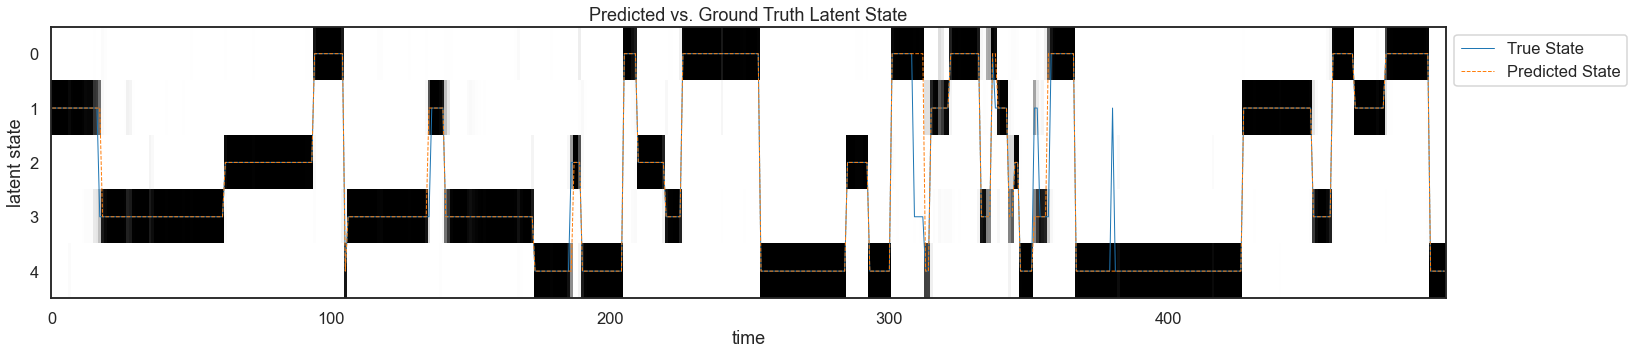

In [25]:
# For the first few trials, let's see how good our predicted states are
for trial_idx in range(3):
    print("=" * 5, f"Trial: {trial_idx}", "=" * 5)
    posterior = test_hmm.smoother(test_params, all_data[trial_idx])
    Ez = posterior.smoothed_probs
    states = all_states[trial_idx]
    perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)